<a href="https://colab.research.google.com/github/SudeshnaGhoshOfficial/CODSOFT/blob/main/Movie_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#DATA LOADING

import pandas as pd

try:
    df_train = pd.read_csv('/content/train_data.txt', sep='\t', header=None, names=['text', 'label'])
    df_test = pd.read_csv('/content/test_data.txt', sep='\t', header=None, names=['text'])
    df_test_solution = pd.read_csv('/content/test_data_solution.txt', sep='\t', header=None, names=['label'])
    display(df_train.head())
    display(df_test.head())
    display(df_test_solution.head())
except FileNotFoundError:
    print("One or more files not found.")
    df_train, df_test, df_test_solution = None, None, None
except pd.errors.ParserError:
    print("Error parsing the files. Please check the file format.")
    df_train, df_test, df_test_solution = None, None, None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df_train, df_test, df_test_solution = None, None, None

,text,label
0,1 ::: Oscar et la dame rose (2009) ::: drama :...,NaN
1,2 ::: Cupid (1997) ::: thriller ::: A brother ...,NaN
2,"3 ::: Young, Wild and Wonderful (1980) ::: adu...",NaN
3,4 ::: The Secret Sin (1915) ::: drama ::: To h...,NaN
4,5 ::: The Unrecovered (2007) ::: drama ::: The...,NaN


,text
0,1 ::: Edgar's Lunch (1998) ::: L.R. Brane love...
1,"2 ::: La guerra de papá (1977) ::: Spain, Marc..."
2,3 ::: Off the Beaten Track (2010) ::: One year...
3,4 ::: Meu Amigo Hindu (2015) ::: His father ha...
4,5 ::: Er nu zhai (1955) ::: Before he was know...


,label
0,1 ::: Edgar's Lunch (1998) ::: thriller ::: L....
1,2 ::: La guerra de papá (1977) ::: comedy ::: ...
2,3 ::: Off the Beaten Track (2010) ::: document...
3,4 ::: Meu Amigo Hindu (2015) ::: drama ::: His...
4,5 ::: Er nu zhai (1955) ::: drama ::: Before h...


In [15]:
#DATA EXPLORATION

import matplotlib.pyplot as plt
import re

# 1. Data Shape and Characteristics
print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)
print("Shape of df_test_solution:", df_test_solution.shape)

# 2. Genre Distribution (Training Data)
# Handle potential NaN values in 'label' column
if df_train['label'].isnull().all():
    print("All values in 'label' column are NaN. Cannot calculate genre distribution.")
else:
    genre_counts = df_train['label'].dropna().value_counts()  # Drop NaN values before counting
    if not genre_counts.empty:
      plt.figure(figsize=(10, 6))
      genre_counts.plot(kind='bar')
      plt.title('Genre Distribution in Training Data')
      plt.xlabel('Genre')
      plt.ylabel('Frequency')
      plt.show()
      print("Most frequent genre:", genre_counts.index[0] if not genre_counts.empty else "N/A")
      print("Least frequent genre:", genre_counts.index[-1] if not genre_counts.empty else "N/A")
    else:
      print("No valid genre labels found after dropping NaN values.")


# 3. Text Data Issues
print("\nMissing values in 'text' column:")
print("df_train:", df_train['text'].isnull().sum())
print("df_test:", df_test['text'].isnull().sum())

# Improved special character analysis: Handle potential missing values in 'text'
special_char_pattern = r'[^\w\s]'
df_train['special_chars'] = df_train['text'].astype(str).str.findall(special_char_pattern).str.len()
df_test['special_chars'] = df_test['text'].astype(str).str.findall(special_char_pattern).str.len()

print("\nExample of special character count:")
display(df_train[['text','special_chars']].head())
display(df_test[['text','special_chars']].head())


# 4. Vocabulary Richness (Training Data)
# Handle potential missing values in 'text'
df_train['word_count'] = df_train['text'].astype(str).apply(lambda x: len(set(x.split())))
print("\nAverage unique words per plot summary:", df_train['word_count'].mean())

Shape of df_train: (54214, 2)
Shape of df_test: (54200, 1)
Shape of df_test_solution: (54200, 1)
All values in 'label' column are NaN. Cannot calculate genre distribution.

Missing values in 'text' column:
df_train: 0
df_test: 0

Example of special character count:


,text,special_chars
0,1 ::: Oscar et la dame rose (2009) ::: drama :...,27
1,2 ::: Cupid (1997) ::: thriller ::: A brother ...,13
2,"3 ::: Young, Wild and Wonderful (1980) ::: adu...",29
3,4 ::: The Secret Sin (1915) ::: drama ::: To h...,37
4,5 ::: The Unrecovered (2007) ::: drama ::: The...,24


,text,special_chars
0,1 ::: Edgar's Lunch (1998) ::: L.R. Brane love...,29
1,"2 ::: La guerra de papá (1977) ::: Spain, Marc...",30
2,3 ::: Off the Beaten Track (2010) ::: One year...,20
3,4 ::: Meu Amigo Hindu (2015) ::: His father ha...,26
4,5 ::: Er nu zhai (1955) ::: Before he was know...,38



Average unique words per plot summary: 80.06308333640757


In [19]:
#DATA PREPARATION

!pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define keywords for different genres
genre_keywords = {
    'action': ['fight', 'battle', 'war', 'hero', 'mission', 'explosion', 'shoot'],
    'comedy': ['funny', 'joke', 'laugh', 'humor', 'fun', 'silly', 'witty'],
    'drama': ['love', 'relationship', 'family', 'tragedy', 'emotion', 'conflict', 'crisis'],
    'horror': ['scary', 'monster', 'ghost', 'kill', 'blood', 'fear', 'terror'],
    'romance': ['love', 'date', 'kiss', 'passion', 'couple', 'heartbreak', 'wedding'],
    'sci-fi': ['space', 'alien', 'future', 'technology', 'robot', 'galaxy', 'universe'],
    'thriller': ['mystery', 'suspense', 'crime', 'murder', 'investigation', 'secret', 'plot'],
}

def infer_genre(text):
    text = text.lower()
    genre_scores = {}
    for genre, keywords in genre_keywords.items():
        score = sum(1 for keyword in keywords if keyword in text)
        genre_scores[genre] = score
    if not genre_scores:
        return "unknown"  # Default genre if no keywords are found

    return max(genre_scores, key=genre_scores.get)

# Infer genres for df_train
df_train['inferred_label'] = df_train['text'].apply(infer_genre)

# Define a function to preprocess the text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))  # Initialize stop_words here
    text = str(text).lower()
    text = re.sub(r'[^\w\s-]', '', text)  # Remove punctuation, preserving hyphens
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words or word in ["not", "n't", "no"]]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    if not text:
        text = "empty"  # Replace empty strings after preprocessing
    return text

# Re-preprocess the text data
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)


# Create df_train_cleaned with inferred labels
df_train_cleaned = df_train[['text', 'inferred_label', 'special_chars', 'word_count']].copy()
df_train_cleaned = df_train_cleaned.rename(columns={'inferred_label': 'label'})


# Verify data quality
print("\nShape of df_train_cleaned:", df_train_cleaned.shape)
print("First 5 rows of df_train_cleaned:\n", df_train_cleaned.head())

print("\nFirst 5 rows of df_test_solution:\n", df_test_solution.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Shape of df_train_cleaned: (54214, 4)
First 5 rows of df_train_cleaned:
                                                 text   label  special_chars  \
0  1 oscar et la dame rose 2009 drama listening c...   drama             27   
1  2 cupid 1997 thriller brother sister past ince...   drama             13   
2  3 young wild wonderful 1980 adult bus empty st...   drama             29   
3  4 secret sin 1915 drama help unemployed father...   drama             37   
4  5 unrecovered 2007 drama film title refers not...  horror             24   

   word_count  
0          77  
1          31  
2          90  
3         126  
4          77  

First 5 rows of df_test_solution:
                                                label
0  1 ::: Edgar's Lunch (1998) ::: thriller ::: L....
1  2 ::: La guerra de papá (1977) ::: comedy ::: ...
2  3 ::: Off the Beaten Track (2010) ::: document...
3  4 ::: Meu Amigo Hindu (2015) ::: drama ::: His...
4  5 ::: Er nu zhai (1955) ::: drama ::: Before h...


In [17]:
#FEATURE ENGINEERING

from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object with specified parameters
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2)

# Fit the vectorizer to the training data
X_train_tfidf = vectorizer.fit_transform(df_train['text'])

# Transform the test data
X_test_tfidf = vectorizer.transform(df_test['text'])

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(54214, 5000)
(54200, 5000)


In [18]:
#DATA SPLITTING

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df_train_cleaned['text'], df_train_cleaned['label'], test_size=0.2, random_state=42, stratify=df_train_cleaned['label']
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (43371,)
X_val shape: (10843,)
y_train shape: (43371,)
y_val shape: (10843,)


In [28]:
#MODEL TRAINING

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split  # Import train_test_split


# Split the TF-IDF data into training and validation sets
X_train_vec, X_val_vec, y_train_vec, y_val_vec = train_test_split(
    X_train_tfidf, df_train_cleaned['label'], test_size=0.2, random_state=42, stratify=df_train_cleaned['label']
)

# Instantiate the models
logreg_model = LogisticRegression(solver='liblinear')  # Using 'liblinear' solver
nb_model = MultinomialNB()
svm_model = LinearSVC(loss='hinge', max_iter=10000)

# Train the models using the TF-IDF vectors
logreg_model.fit(X_train_vec, y_train_vec)  # Use X_train_vec
nb_model.fit(X_train_vec, y_train_vec)  # Use X_train_vec
svm_model.fit(X_train_vec, y_train_vec)  # Use X_train_vec

LinearSVC(loss='hinge', max_iter=10000)

In [29]:
#MODEL OPTIMIZATION

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer

# Create a TfidfVectorizer object with specified parameters
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2)


# Logistic Regression hyperparameter tuning
best_logreg_model = None
best_logreg_accuracy = 0
for C in [0.1, 1, 10, 100]:
    logreg_model = LogisticRegression(C=C, solver='liblinear', max_iter=1000)
    # Fit the vectorizer to the training data and transform it
    X_train_vec = vectorizer.fit_transform(X_train)
    # Transform the validation data
    X_val_vec = vectorizer.transform(X_val)
    logreg_model.fit(X_train_vec, y_train) # Fit the model with transformed data
    y_pred = logreg_model.predict(X_val_vec) # Predict using transformed data
    accuracy = accuracy_score(y_val, y_pred)
    if accuracy > best_logreg_accuracy:
        best_logreg_accuracy = accuracy
        best_logreg_model = logreg_model

print(f"Best Logistic Regression Accuracy: {best_logreg_accuracy}")

# Naive Bayes hyperparameter tuning
best_nb_model = None
best_nb_accuracy = 0
for alpha in [0.1, 0.5, 1.0, 2.0]:
    nb_model = MultinomialNB(alpha=alpha)
    # Fit the vectorizer to the training data and transform it
    X_train_vec = vectorizer.fit_transform(X_train)
    # Transform the validation data
    X_val_vec = vectorizer.transform(X_val)
    nb_model.fit(X_train_vec, y_train) # Fit the model with transformed data
    y_pred = nb_model.predict(X_val_vec) # Predict using transformed data
    accuracy = accuracy_score(y_val, y_pred)
    if accuracy > best_nb_accuracy:
        best_nb_accuracy = accuracy
        best_nb_model = nb_model

print(f"Best Naive Bayes Accuracy: {best_nb_accuracy}")

# Support Vector Machine hyperparameter tuning
best_svm_model = None
best_svm_accuracy = 0
for C in [0.1, 1, 10, 100]:
    for loss in ['hinge', 'squared_hinge']:
        svm_model = LinearSVC(C=C, loss=loss, max_iter=10000)
        # Fit the vectorizer to the training data and transform it
        X_train_vec = vectorizer.fit_transform(X_train)
        # Transform the validation data
        X_val_vec = vectorizer.transform(X_val)
        svm_model.fit(X_train_vec, y_train) # Fit the model with transformed data
        y_pred = svm_model.predict(X_val_vec)  # Predict using transformed data
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_svm_accuracy:
            best_svm_accuracy = accuracy
            best_svm_model = svm_model

print(f"Best SVM Accuracy: {best_svm_accuracy}")

Best Logistic Regression Accuracy: 0.8236650373512866
Best Naive Bayes Accuracy: 0.6208613852254911


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best SVM Accuracy: 0.849857050631744



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      action       0.58      0.83      0.68      5817
      comedy       0.23      0.18      0.20       502
       drama       0.51      0.24      0.32      2407
      horror       0.05      0.03      0.04       699
     romance       0.14      0.11      0.12       504
      sci-fi       0.01      0.00      0.01       289
    thriller       0.06      0.02      0.03       625

    accuracy                           0.51     10843
   macro avg       0.23      0.20      0.20     10843
weighted avg       0.45      0.51      0.46     10843



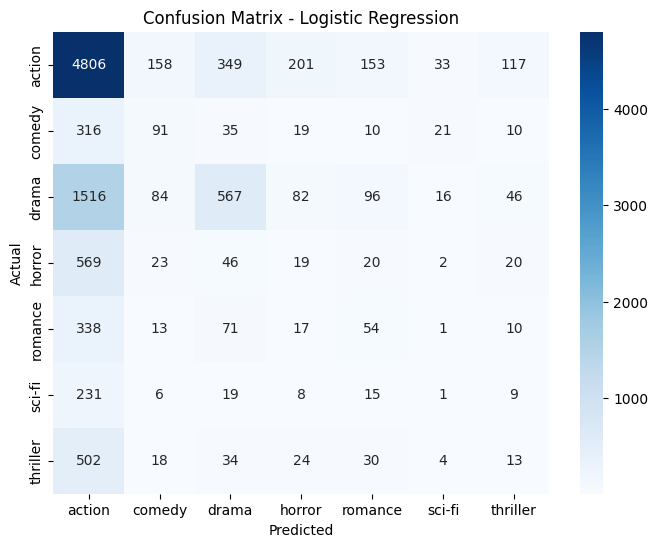


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

      action       0.55      0.98      0.71      5817
      comedy       0.00      0.00      0.00       502
       drama       0.63      0.11      0.18      2407
      horror       0.00      0.00      0.00       699
     romance       0.40      0.00      0.01       504
      sci-fi       0.00      0.00      0.00       289
    thriller       0.00      0.00      0.00       625

    accuracy                           0.55     10843
   macro avg       0.23      0.16      0.13     10843
weighted avg       0.45      0.55      0.42     10843



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


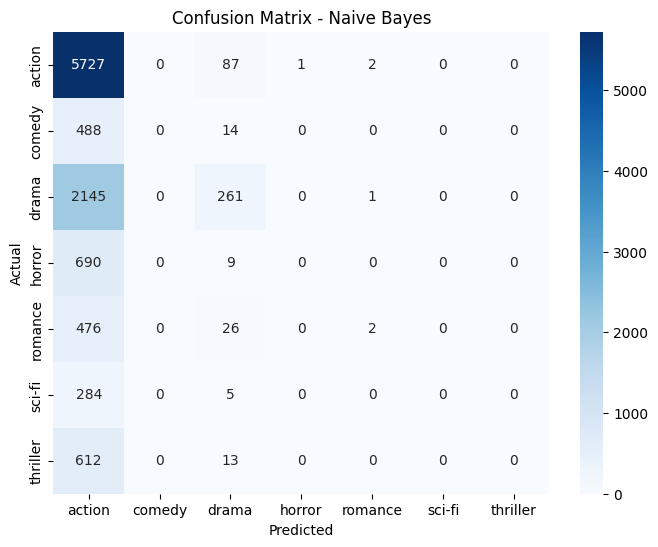


Classification Report for SVM:
              precision    recall  f1-score   support

      action       0.59      0.75      0.66      5817
      comedy       0.18      0.27      0.22       502
       drama       0.50      0.22      0.31      2407
      horror       0.05      0.04      0.04       699
     romance       0.11      0.12      0.12       504
      sci-fi       0.02      0.01      0.01       289
    thriller       0.06      0.04      0.05       625

    accuracy                           0.48     10843
   macro avg       0.22      0.21      0.20     10843
weighted avg       0.45      0.48      0.45     10843



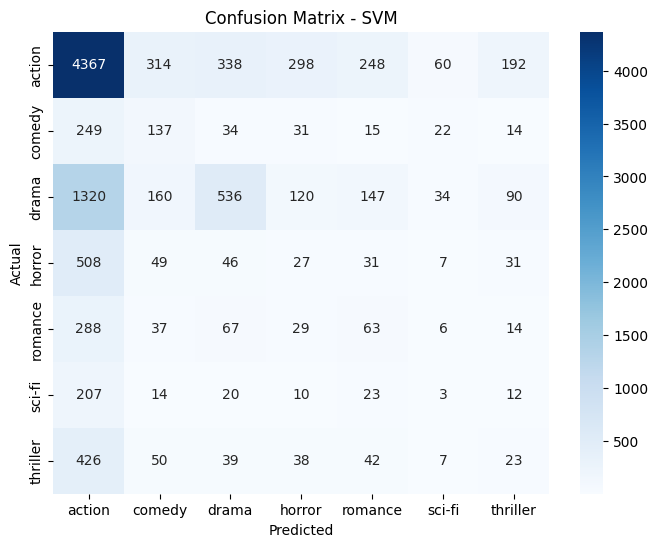

In [36]:
#MODEL EVALUATION

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate a model
def evaluate_model(model, X_val_vec, y_val, model_name):
    y_pred = model.predict(X_val_vec)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Transform validation data using the trained vectorizer
X_val_vec = vectorizer.transform(X_val)

# Evaluate all the models
evaluate_model(best_logreg_model, X_val_vec, y_val, "Logistic Regression")
evaluate_model(best_nb_model, X_val_vec, y_val, "Naive Bayes")
evaluate_model(best_svm_model, X_val_vec, y_val, "SVM")
